In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FILE_NAME="Console_Acq_0012.mat"

In [3]:
mat_contents = scipy.io.loadmat(f'doric/{FILE_NAME}')

Events shape: (1, 8)
Event structure: ('RawTrace', 'RawTime', 'RawTrace_z', 'Channel', 'WaveformTime', 'Waveforms', 'EventTimes', 'Clusters', 'ClusterSize', 'PCs', 'StimOn', 'StimOff')
Raw trace shape: (10937824,)
Raw time shape: (10937824,)
Time range: 0.000000 to 364.776397
Voltage range: -0.162519 to 0.080281


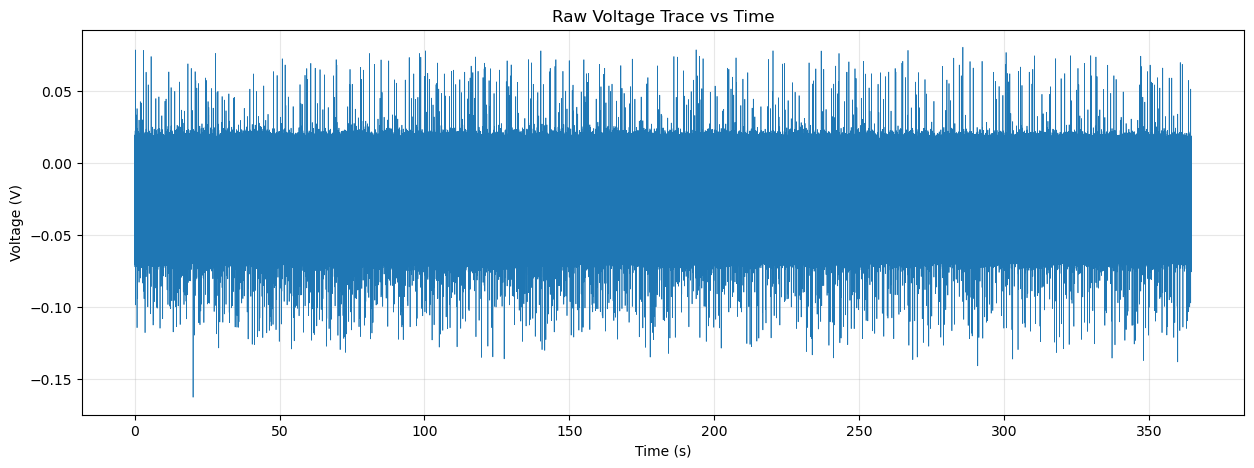

In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load the data
mat_contents = scipy.io.loadmat('doric/Console_Acq_0012.mat')
events = mat_contents['Events']

print("Events shape:", events.shape)

# The third event (index 2) contains the actual data
event = events[0, 2]  # Access the third event which has data

print("Event structure:", event.dtype.names)

# Extract the voltage trace and time data
raw_trace = event[0].flatten()  # First element is RawTrace
raw_time = event[1].flatten()   # Second element is RawTime

print(f"Raw trace shape: {raw_trace.shape}")
print(f"Raw time shape: {raw_time.shape}")
print(f"Time range: {raw_time.min():.6f} to {raw_time.max():.6f}")
print(f"Voltage range: {raw_trace.min():.6f} to {raw_trace.max():.6f}")

# Plot the voltage trace
plt.figure(figsize=(15, 5))
plt.plot(raw_time, raw_trace, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Raw Voltage Trace vs Time')
plt.grid(True, alpha=0.3)
plt.show()

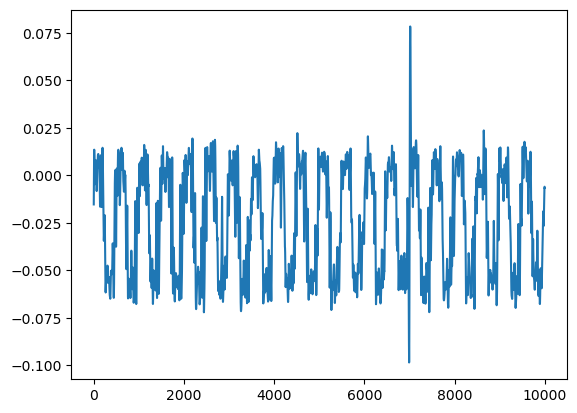

In [5]:
plt.plot(raw_trace[:10000])
plt.show()

In [6]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(raw_trace, height=0.06)

print(f"Found {len(peaks)} peaks")
print(f"Peak indices: {peaks[:10]}")

Found 143 peaks
Peak indices: [   7017   91502  117484  169484  352965  550380  584938  624985  836249
 1229563]


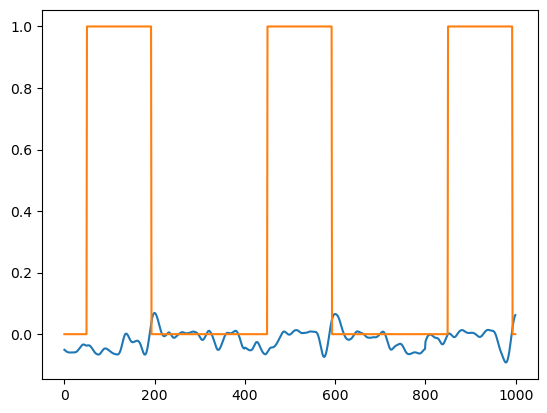

In [7]:
voltage_data = []

PAD = 200

for i in peaks:
    voltage_data.extend(raw_trace[i-PAD:i+PAD])

#----
time_step = raw_time[1] - raw_time[0]
time_data = np.arange(0, len(voltage_data) * time_step, time_step)

#----
labels = []

for i in peaks:
    start_idx = max(0, i - PAD)
    end_idx = min(len(raw_trace), i + PAD)
    
    segment_labels = [0] * (end_idx - start_idx)
    
    label_start = max(0, i - 150 - start_idx)
    label_end = min(len(segment_labels), i - 7 - start_idx)
    
    if label_end > label_start:
        segment_labels[label_start:label_end] = [1] * (label_end - label_start)
    
    labels.extend(segment_labels)

#----
plt.plot(voltage_data[2000:3000])
plt.plot(labels[2000:3000])
plt.show()

In [9]:
from scipy.signal import stft

def sliding_stft_with_labels(voltage_data, labels, window_size=100, step=10):
    features = []
    times = []
    window_labels = []
    
    for i in range(0, len(voltage_data) - window_size, step):
        # Extract window
        window = voltage_data[i:i+window_size]
        time = raw_time[i:i+window_size]
        # Get STFT
        f, t, Zxx = stft(window, nperseg=50, noverlap=25)
        features.append(np.abs(Zxx).flatten())
        times.append(time)
        # Get majority label for this window
        window_label = 1 if np.mean(labels[i:i+window_size]) > 0.5 else 0
        window_labels.append(window_label)
    
    return np.array(features), np.array(window_labels), np.array(times)

features, window_labels, times = sliding_stft_with_labels(voltage_data, labels, window_size=100, step=10)

print(f"Features shape: {features.shape}")
print(f"Labels shape: {window_labels.shape}")
print(f"Times shape: {times.shape}")

Features shape: (5710, 130)
Labels shape: (5710,)
Times shape: (5710, 100)


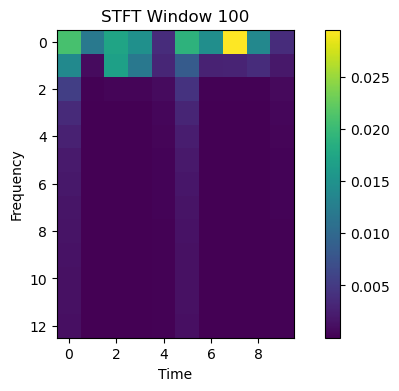

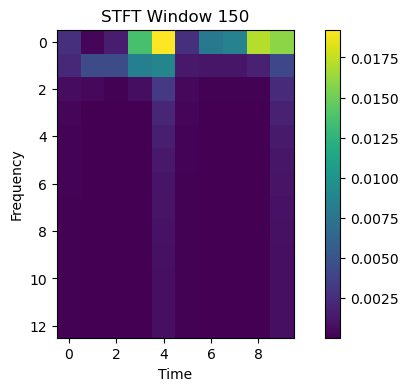

In [10]:
for i in range(100, 200, 50):
    plt.figure(figsize=(8, 4))
    plt.imshow(features[i].reshape(13, 10))  # Reshape to 2D for imshow
    plt.colorbar()
    plt.title(f'STFT Window {i}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()